<a href="https://colab.research.google.com/github/jennsitta/jennsitta/blob/main/palmRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install opencv-python scikit-learn numpy matplotlib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing palm images...

Training classifier...
Models saved successfully.

1. Test image
2. Exit
Choose option: 1


Saving img 4.jpg to img 4.jpg

=== Recognition Result ===
✅ Recognized as: person 1 (98.5% confidence)


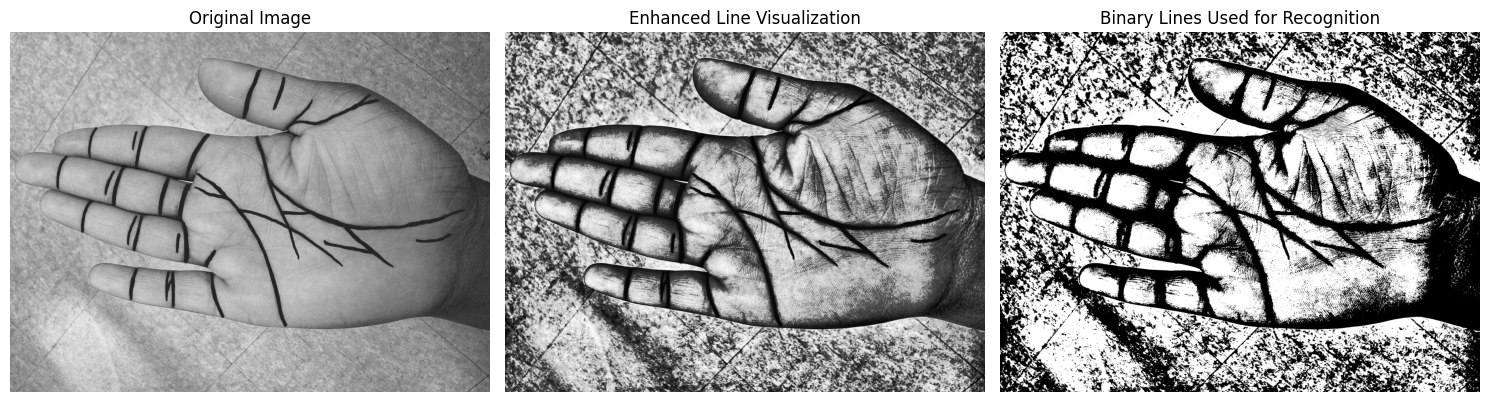


1. Test image
2. Exit
Choose option: 1


Saving img 10.jpg to img 10.jpg

=== Recognition Result ===
✅ Recognized as: person 1 (98.5% confidence)


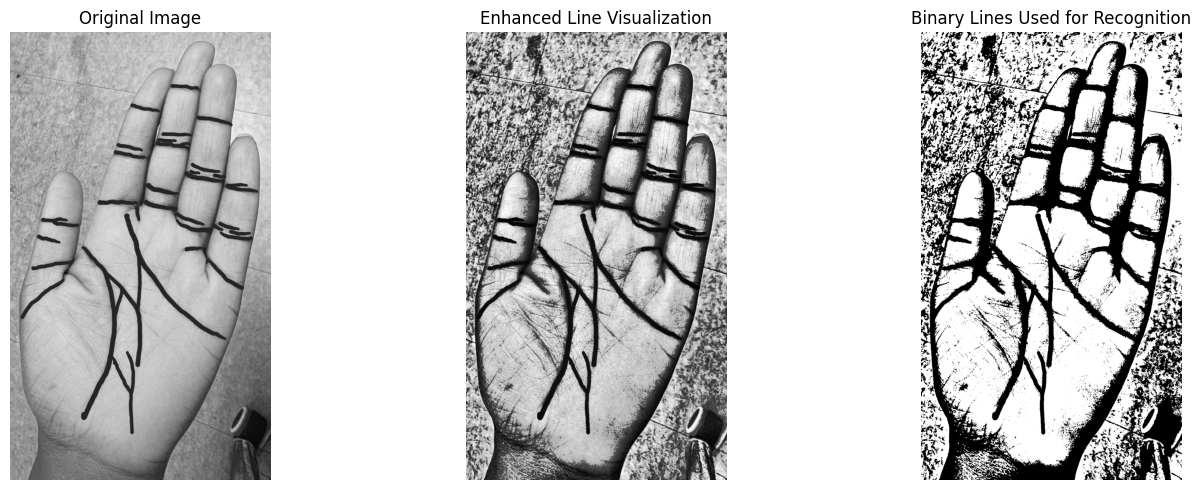


1. Test image
2. Exit
Choose option: 1


Saving img 3.jpg to img 3.jpg

=== Recognition Result ===
✅ Recognized as: person 2 (98.2% confidence)


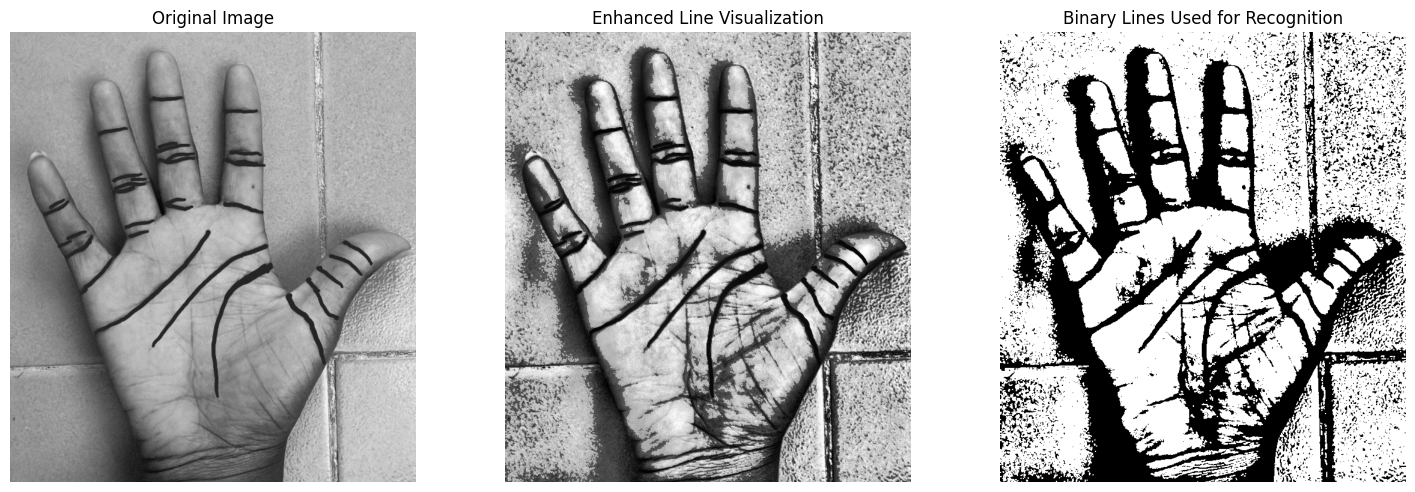


1. Test image
2. Exit
Choose option: 1


Saving img 7.jpg to img 7.jpg

=== Recognition Result ===
✅ Recognized as: person 2 (98.2% confidence)


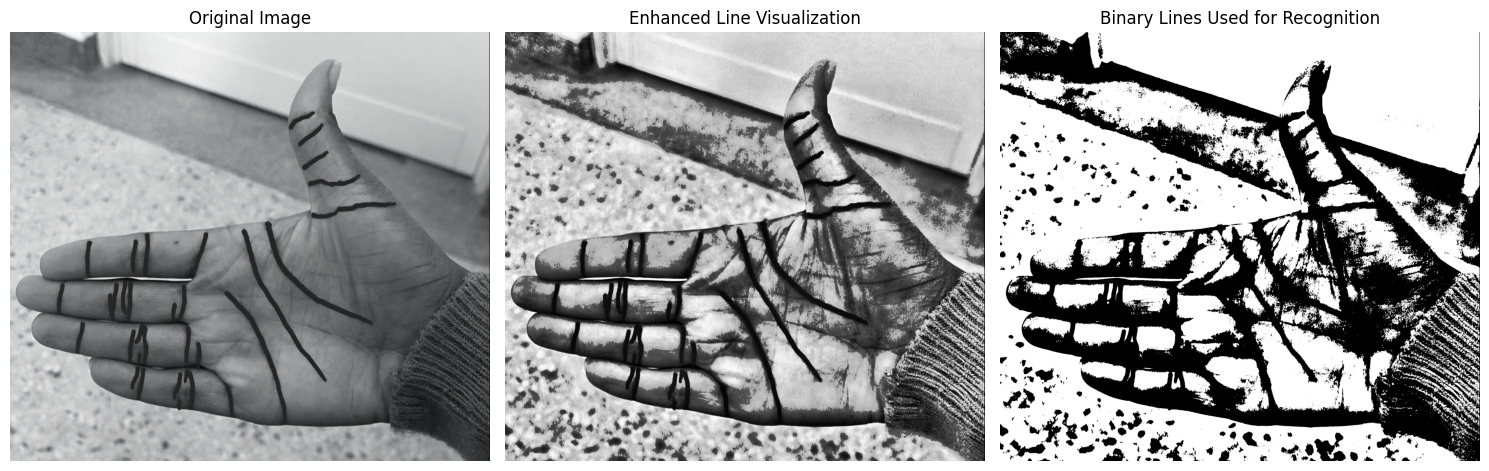


1. Test image
2. Exit
Choose option: 1


Saving KakaoTalk_20250623_184404866_05.jpg to KakaoTalk_20250623_184404866_05 (1).jpg

=== Recognition Result ===
✅ Recognized as: person 1 (92.5% confidence)


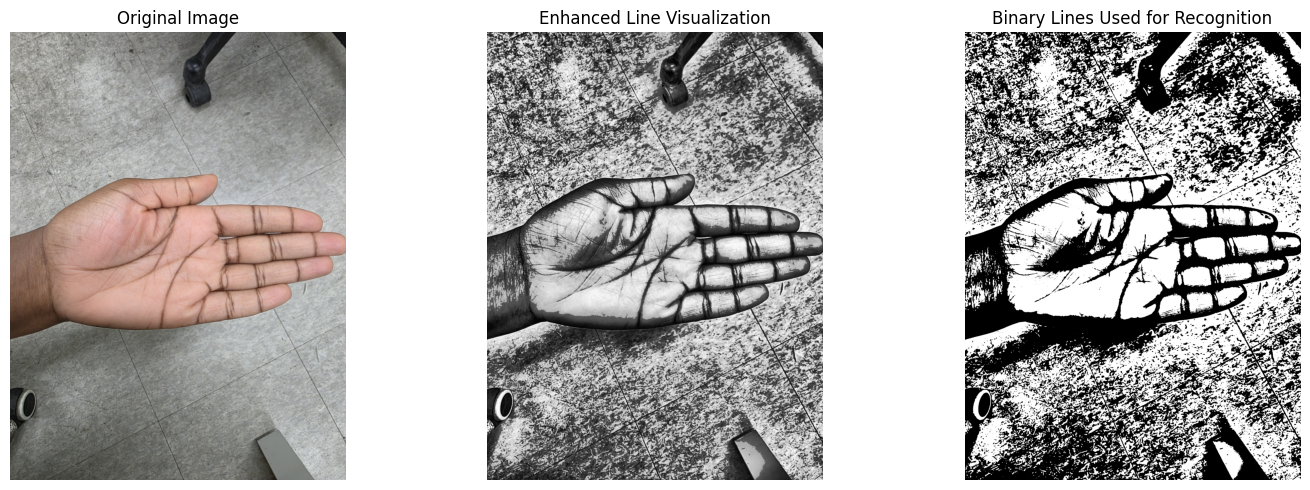


1. Test image
2. Exit
Choose option: 1


Saving KakaoTalk_20250623_184459426_01.jpg to KakaoTalk_20250623_184459426_01.jpg

=== Recognition Result ===
✅ Recognized as: person 2 (79.3% confidence)


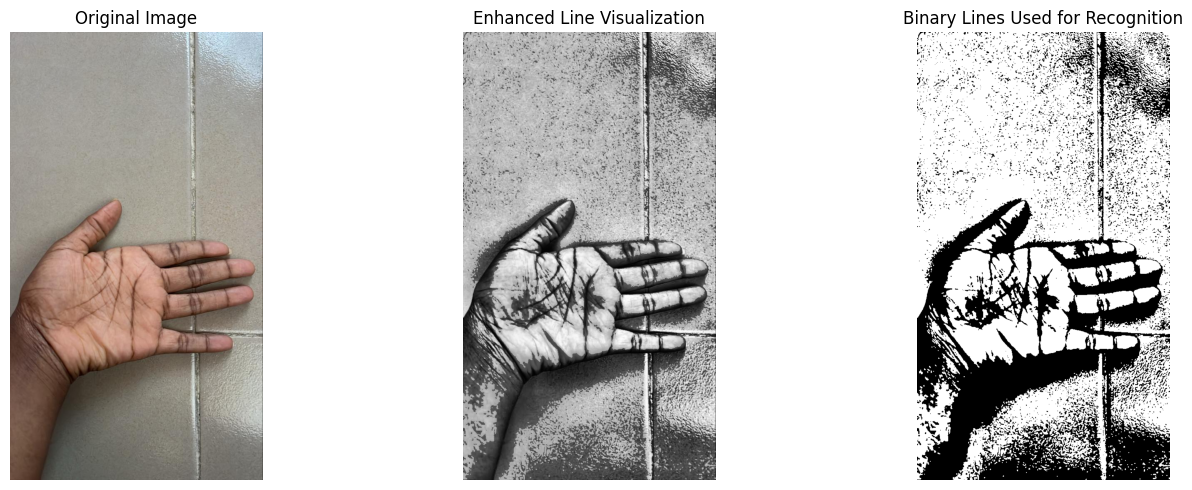


1. Test image
2. Exit
Choose option: 1


Saving KakaoTalk_20250623_184459426_02.jpg to KakaoTalk_20250623_184459426_02.jpg

=== Recognition Result ===
✅ Recognized as: person 2 (88.4% confidence)


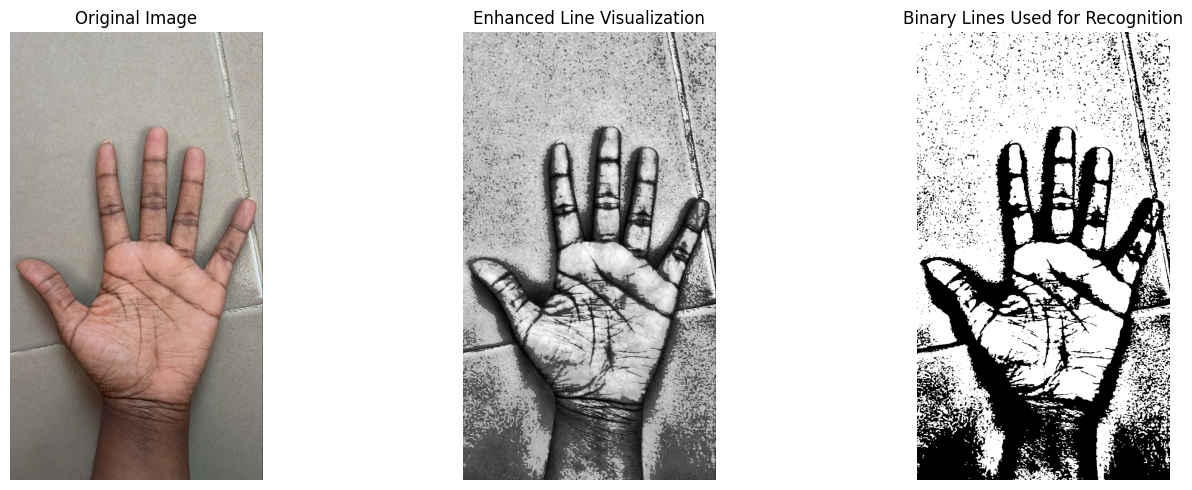


1. Test image
2. Exit
Choose option: 1


Saving IMG-20250331-WA0058.jpg to IMG-20250331-WA0058.jpg

=== Recognition Result ===
❌ Rejected: Low confidence (51.7%)


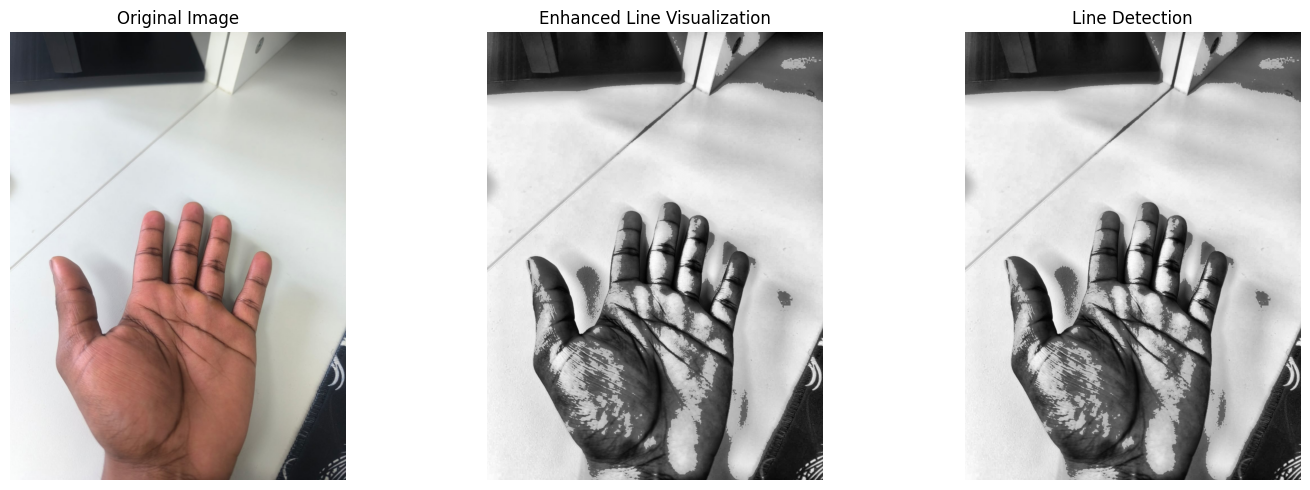


1. Test image
2. Exit
Choose option: 1


Saving IMG-20250331-WA0062.jpg to IMG-20250331-WA0062.jpg

=== Recognition Result ===
❌ Rejected: Low confidence (56.0%)


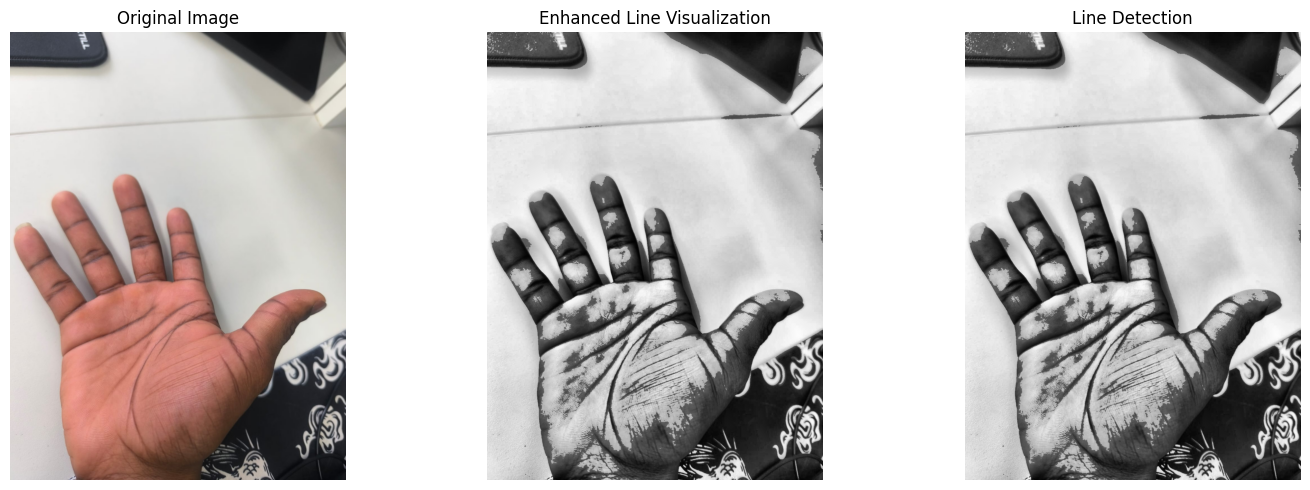


1. Test image
2. Exit
Choose option: 2
System closed.


In [7]:
# 1. Install packages
!pip install opencv-python scikit-learn matplotlib

# 2. Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import joblib
from google.colab import drive, files
import os # Import the os module

# Mount Google Drive
drive.mount('/content/drive')

# Configuration
PALM_DATA_DIR = '/content/drive/MyDrive/datacurrent'
MODEL_PATH = '/content/drive/MyDrive/palm_line_model.pkl'
ENCODER_PATH = '/content/drive/MyDrive/label_encoder.pkl'

# 3. Enhanced Palm Line Extraction (with better visualization)
def extract_palm_lines(image, visualize=False):
    """Improved line extraction with better contrast for visualization"""
    # Convert to grayscale if needed
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image.copy()

    # Enhanced contrast adjustment
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(12, 12))  # Increased clip limit
    enhanced = clahe.apply(gray)

    # Optimized thresholding
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Clean up the binary image
    kernel = np.ones((2,2), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    # Create visualization-friendly version
    if visualize:
        # Blend original with lines for better visibility
        vis_lines = cv2.addWeighted(enhanced, 0.7, cleaned, 0.3, 0)
        return cleaned, vis_lines

    return cleaned

# 4. Feature Extraction (unchanged)
def get_line_features(line_image):
    """Same effective line pattern features"""
    resized = cv2.resize(line_image, (128, 128))
    horizontal = cv2.reduce(resized, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    vertical = cv2.reduce(resized, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    return np.concatenate([horizontal.flatten(), vertical.flatten()])

# 5. Load and Process Dataset (unchanged)
print("Processing palm images...")
features = []
labels = []
class_names = sorted(os.listdir(PALM_DATA_DIR))

for class_name in class_names:
    class_dir = os.path.join(PALM_DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        try:
            img = cv2.imread(img_path)
            lines = extract_palm_lines(img)
            if np.sum(lines) < 10000:
                print(f"Skipping {img_path} - insufficient lines")
                continue
            features.append(get_line_features(lines))
            labels.append(class_name)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# 6. Train Classifier (unchanged)
print("\nTraining classifier...")
le = LabelEncoder()
clf = SVC(kernel='rbf', probability=True, class_weight='balanced')
clf.fit(np.array(features), le.fit_transform(labels))

# Save models
joblib.dump(clf, MODEL_PATH)
joblib.dump(le, ENCODER_PATH)
print("Models saved successfully.")

# 7. Enhanced Recognition Function with Better Visualization
def recognize_palm(image_path, min_confidence=0.7):
    """Recognizes palms with improved line visualization"""
    try:
        img = cv2.imread(image_path)

        # Get both processing and visualization versions
        lines, vis_lines = extract_palm_lines(img, visualize=True)

        # Check line content
        line_pixels = np.sum(lines)
        if line_pixels < 10000:
            return {
                "status": "rejected",
                "reason": f"Insufficient lines ({line_pixels} pixels)",
                "visualization": vis_lines
            }

        # Predict
        features = get_line_features(lines)
        proba = clf.predict_proba([features])[0]
        best_class = np.argmax(proba)
        confidence = proba[best_class]

        if confidence < min_confidence:
            return {
                "status": "rejected",
                "reason": f"Low confidence ({confidence:.1%})",
                "visualization": vis_lines
            }

        return {
            "status": "recognized",
            "class": le.inverse_transform([best_class])[0],
            "confidence": float(confidence),
            "visualization": vis_lines,
            "binary_lines": lines
        }

    except Exception as e:
        return {"status": "error", "reason": str(e)}

# 8. Improved Test Function with Enhanced Display
def test_palm_recognition(image_path):
    """Test recognition with superior visualization"""
    result = recognize_palm(image_path)

    print("\n=== Recognition Result ===")
    if result["status"] == "recognized":
        print(f"✅ Recognized as: {result['class']} ({result['confidence']:.1%} confidence)")
    else:
        print(f"❌ Rejected: {result['reason']}")

    # Display results
    img = cv2.imread(image_path)
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Enhanced Line Visualization
    plt.subplot(1, 3, 2)
    plt.imshow(result["visualization"], cmap='gray')
    plt.title("Enhanced Line Visualization")
    plt.axis('off')

    # Binary Lines (for verification)
    plt.subplot(1, 3, 3)
    if "binary_lines" in result:
        plt.imshow(result["binary_lines"], cmap='gray')
        plt.title("Binary Lines Used for Recognition")
    else:
        plt.imshow(result["visualization"], cmap='gray')
        plt.title("Line Detection")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 9. Run the system
while True:
    print("\n1. Test image")
    print("2. Exit")
    choice = input("Choose option: ")

    if choice == "1":
        uploaded = files.upload()
        if uploaded:
            test_palm_recognition(list(uploaded.keys())[0])
    elif choice == "2":
        break

print("System closed.")